In [1]:
import pandas as pd
df = pd.read_csv('../Data/Cleaned_data.csv')
df['BoGender'].value_counts()

BoGender
1    489015
2    166485
3     25367
Name: count, dtype: int64

In [2]:
df = df[df['BoGender'] != 3]
min_count = df['BoGender'].value_counts().min()
df = df.groupby('BoGender').sample(n=min_count, random_state=42)
df = df.reset_index(drop=True)
df['BoGender'].value_counts()

BoGender
1    166485
2    166485
Name: count, dtype: int64


Training/Testing Split: 90%/10%

Model: ZeroR
 Accuracy: 0.4972, Precision: 0.7486, Recall: 0.5000, F1-Score: 0.3321, Specificity: 0.5000
Time taken: 0.03 seconds

Model: SGD Classifier
 Accuracy: 0.5028, Precision: 0.2514, Recall: 0.5000, F1-Score: 0.3346, Specificity: 0.5000
Time taken: 21.31 seconds

Model: Random Forest
 Accuracy: 0.8305, Precision: 0.8396, Recall: 0.8310, F1-Score: 0.8295, Specificity: 0.8310
Time taken: 63.59 seconds

Model: Decision Tree
 Accuracy: 0.7694, Precision: 0.7694, Recall: 0.7694, F1-Score: 0.7694, Specificity: 0.7694
Time taken: 5.80 seconds

Model: Extra Trees
 Accuracy: 0.8300, Precision: 0.8407, Recall: 0.8305, F1-Score: 0.8287, Specificity: 0.8305
Time taken: 27.45 seconds

Model: Gradient Boosting
 Accuracy: 0.8305, Precision: 0.8468, Recall: 0.8311, F1-Score: 0.8287, Specificity: 0.8311
Time taken: 65.71 seconds

Model: KNN
 Accuracy: 0.5400, Precision: 0.5494, Recall: 0.5387, F1-Score: 0.5128, Specificity: 0.5387
Time taken: 3.23 seconds

Resu

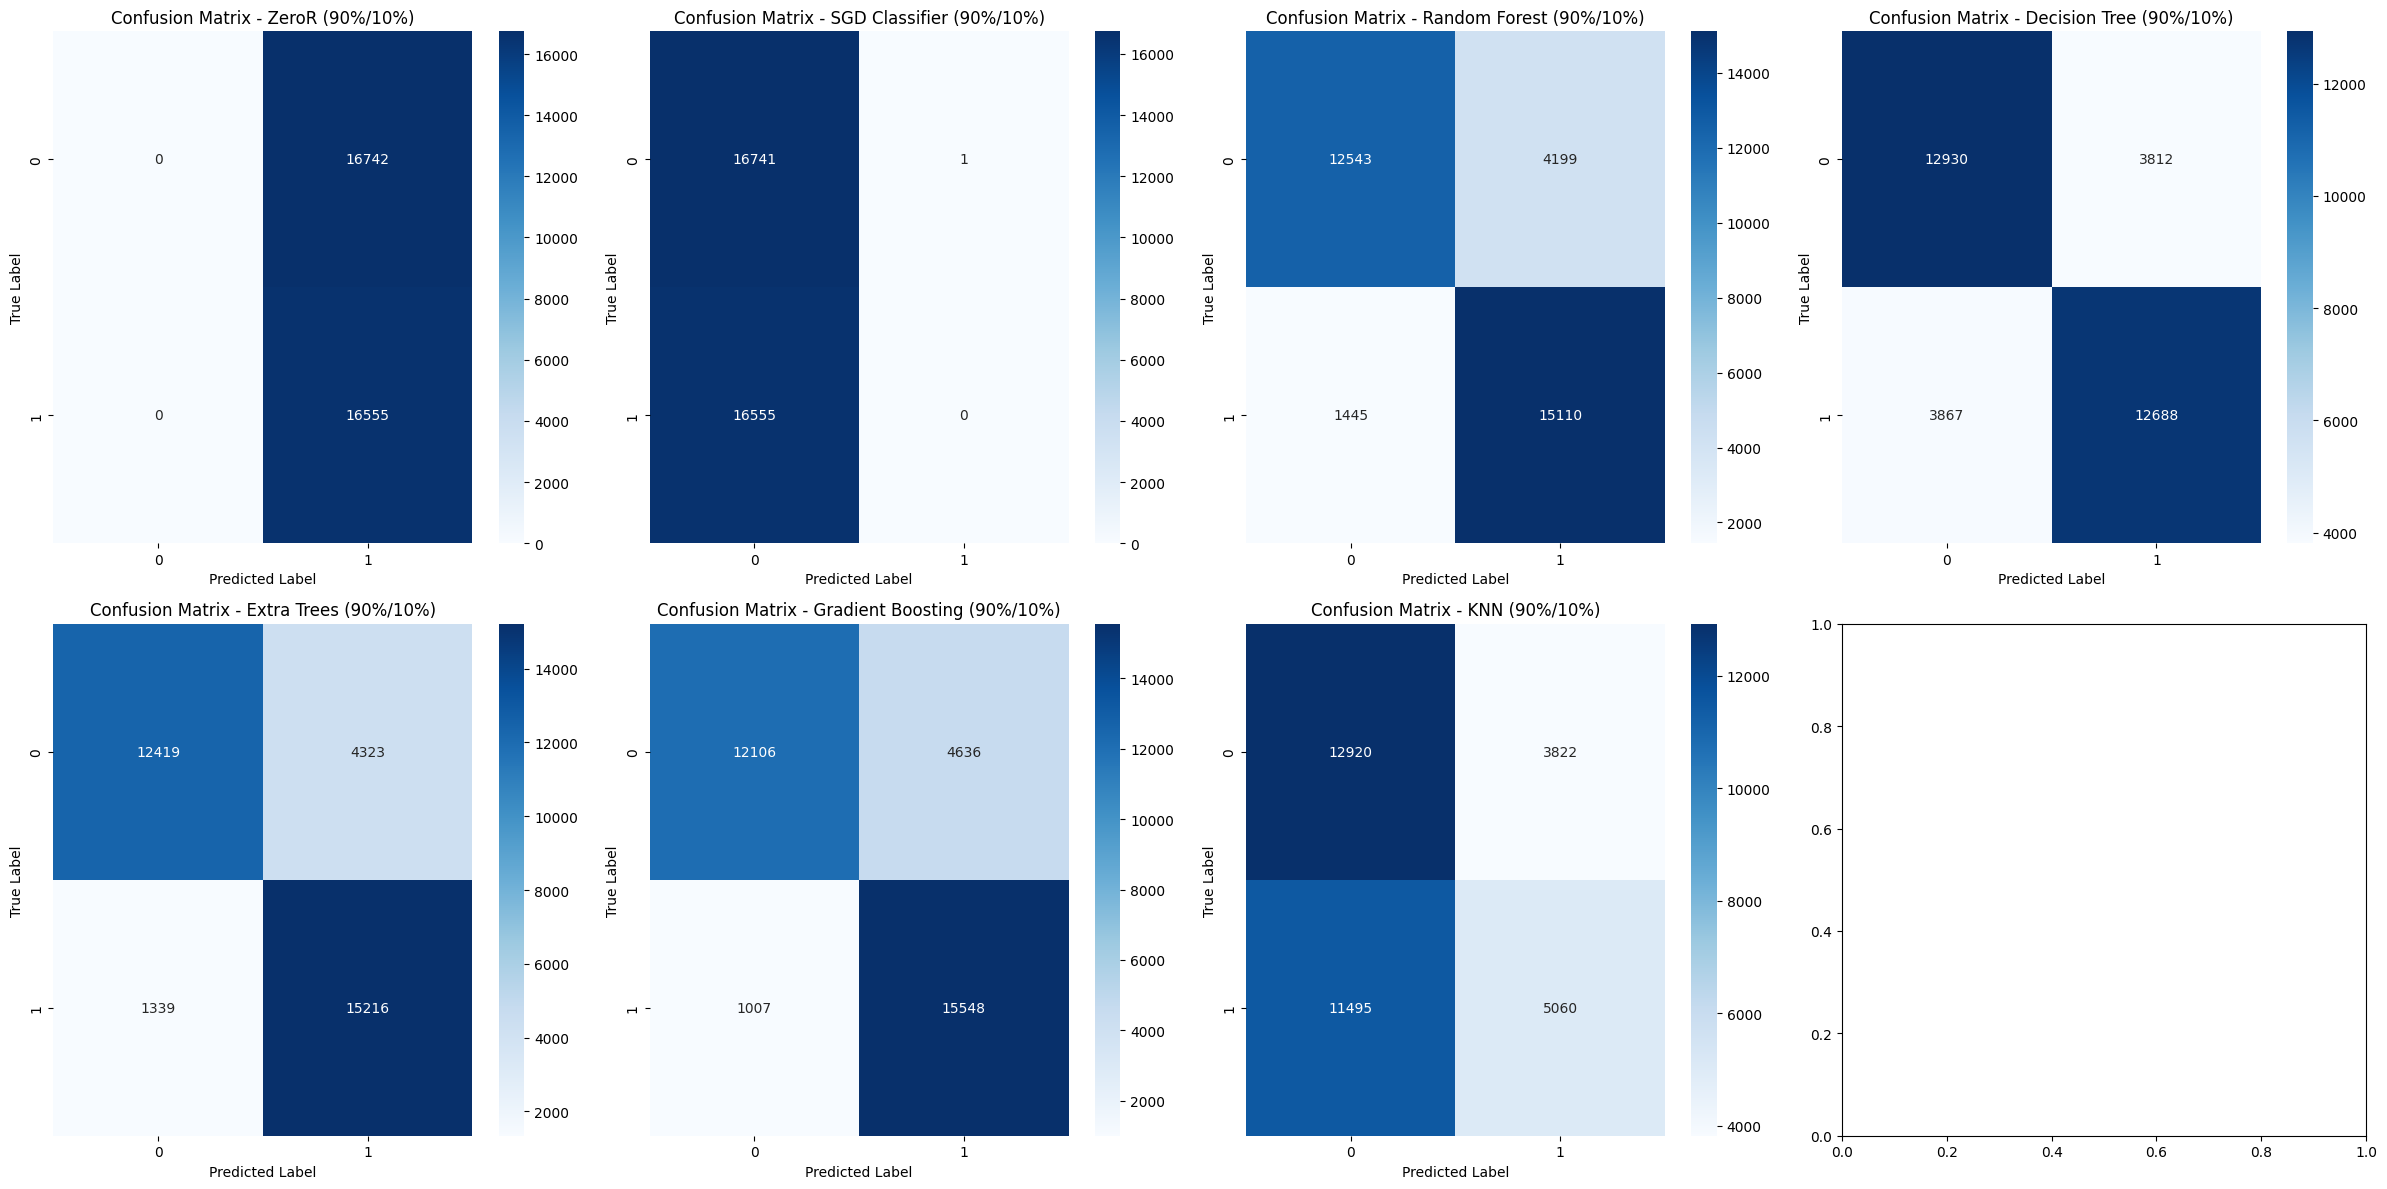


Training/Testing Split: 80%/20%

Model: ZeroR
 Accuracy: 0.4993, Precision: 0.7496, Recall: 0.5000, F1-Score: 0.3330, Specificity: 0.5000
Time taken: 0.04 seconds

Model: SGD Classifier
 Accuracy: 0.5220, Precision: 0.6279, Recall: 0.5214, F1-Score: 0.3959, Specificity: 0.5214
Time taken: 20.63 seconds

Model: Random Forest
 Accuracy: 0.8303, Precision: 0.8389, Recall: 0.8304, F1-Score: 0.8292, Specificity: 0.8304
Time taken: 56.62 seconds

Model: Decision Tree
 Accuracy: 0.7678, Precision: 0.7678, Recall: 0.7678, F1-Score: 0.7678, Specificity: 0.7678
Time taken: 5.19 seconds

Model: Extra Trees
 Accuracy: 0.8271, Precision: 0.8379, Recall: 0.8272, F1-Score: 0.8257, Specificity: 0.8272
Time taken: 24.08 seconds

Model: Gradient Boosting
 Accuracy: 0.8297, Precision: 0.8464, Recall: 0.8298, F1-Score: 0.8276, Specificity: 0.8298
Time taken: 57.30 seconds

Model: KNN
 Accuracy: 0.5400, Precision: 0.5507, Recall: 0.5396, F1-Score: 0.5133, Specificity: 0.5396
Time taken: 5.41 seconds

Resu

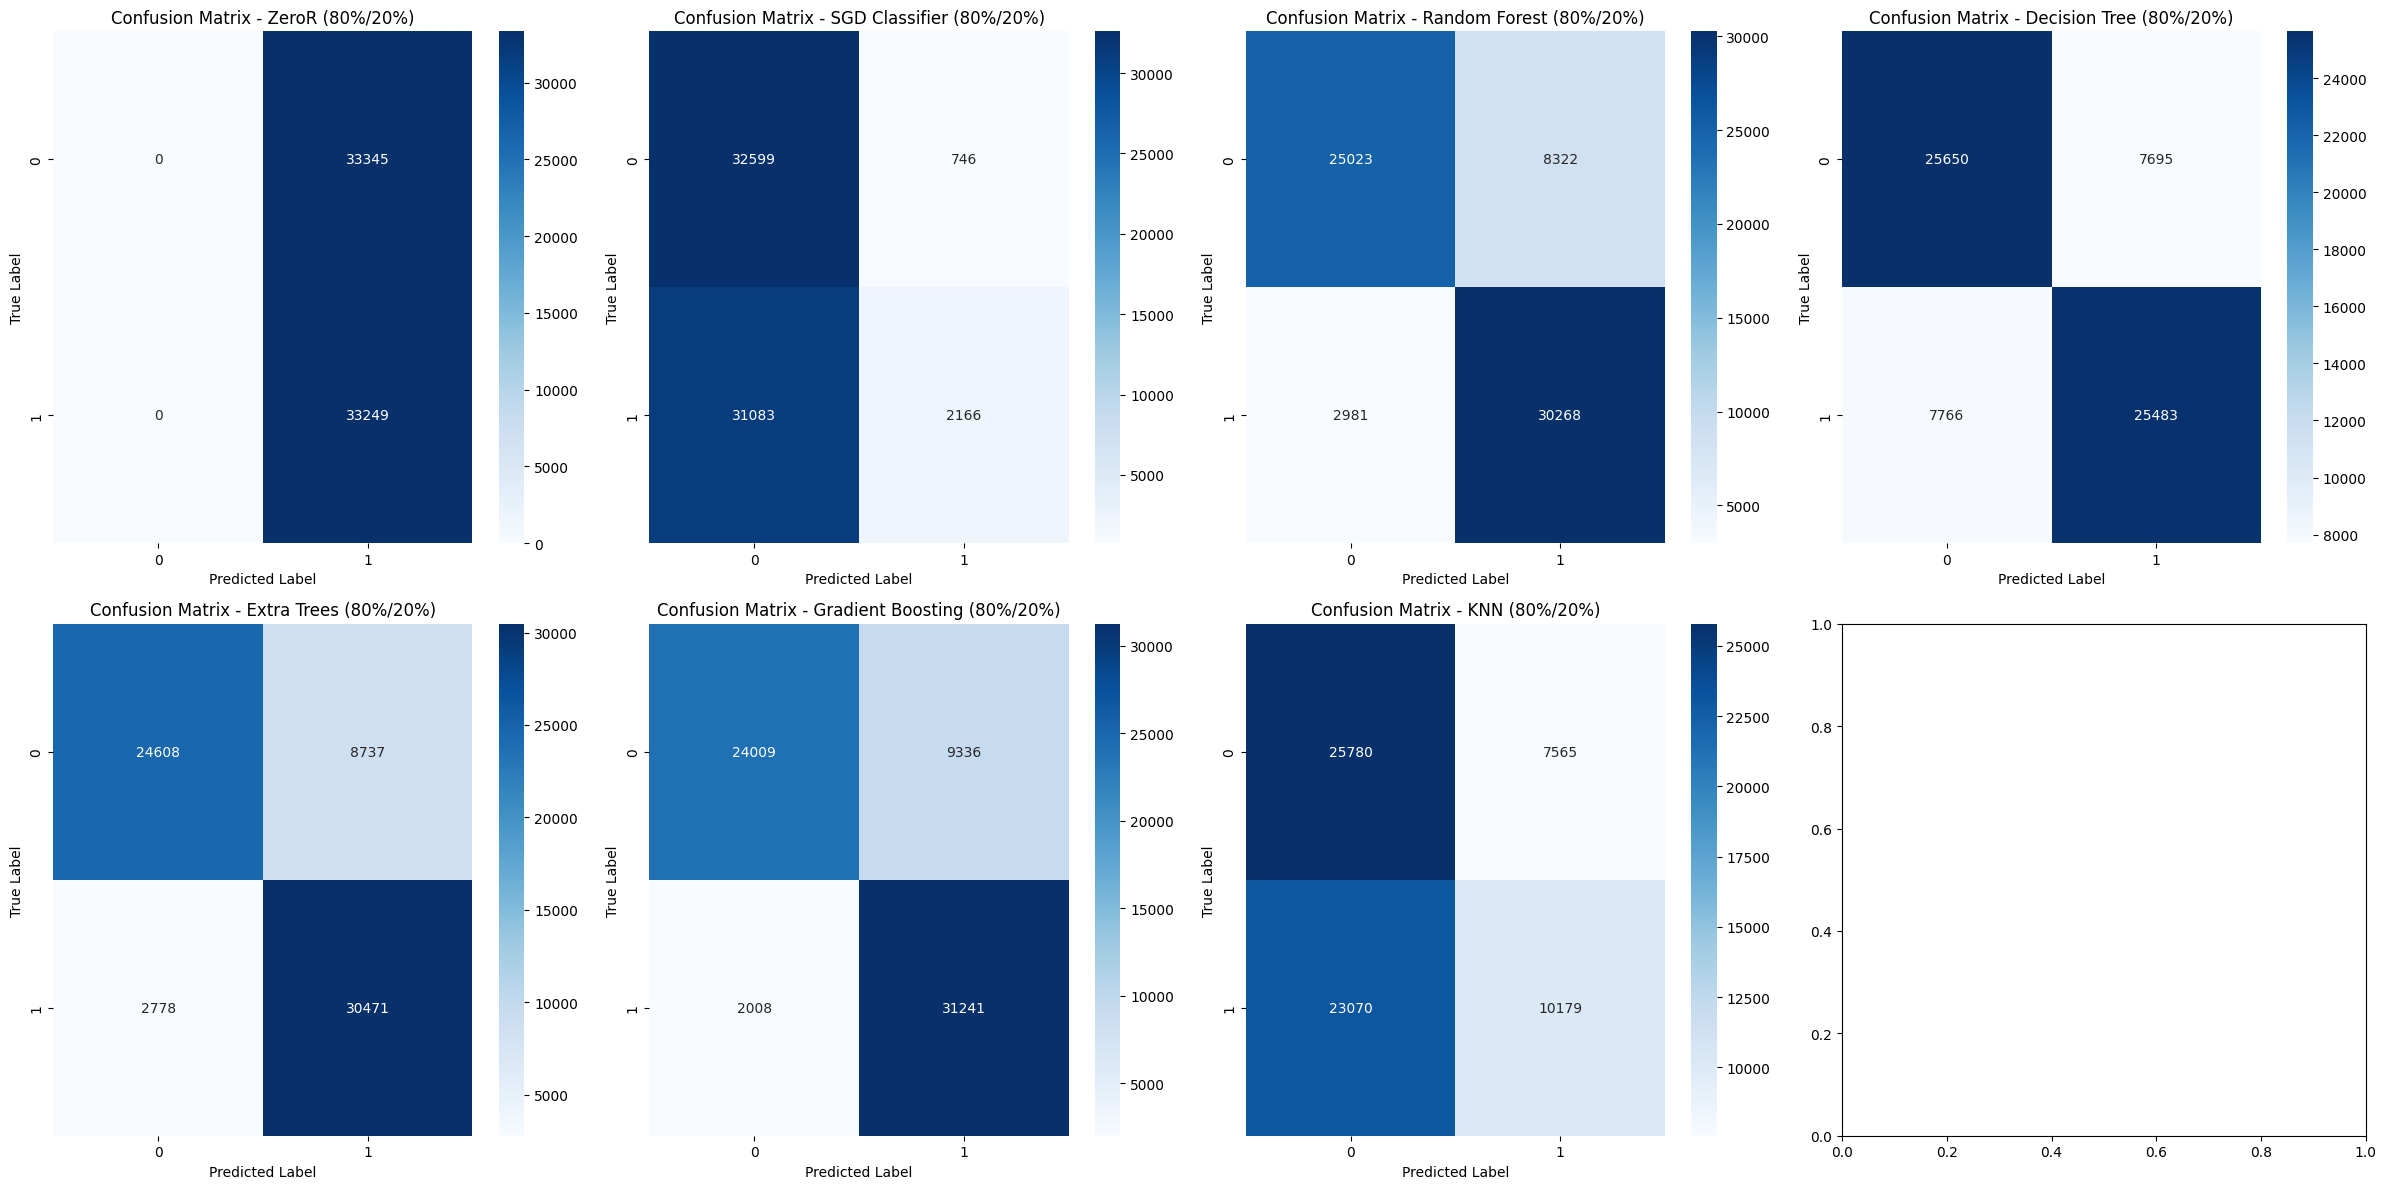


Training/Testing Split: 70%/30%

Model: ZeroR
 Accuracy: 0.4990, Precision: 0.7495, Recall: 0.5000, F1-Score: 0.3329, Specificity: 0.5000
Time taken: 0.05 seconds

Model: SGD Classifier
 Accuracy: 0.5023, Precision: 0.6297, Recall: 0.5013, F1-Score: 0.3379, Specificity: 0.5013
Time taken: 15.62 seconds

Model: Random Forest
 Accuracy: 0.8297, Precision: 0.8383, Recall: 0.8296, F1-Score: 0.8286, Specificity: 0.8296
Time taken: 48.80 seconds

Model: Decision Tree
 Accuracy: 0.7699, Precision: 0.7700, Recall: 0.7700, F1-Score: 0.7699, Specificity: 0.7700
Time taken: 4.49 seconds

Model: Extra Trees
 Accuracy: 0.8284, Precision: 0.8392, Recall: 0.8282, F1-Score: 0.8270, Specificity: 0.8282
Time taken: 21.86 seconds

Model: Gradient Boosting
 Accuracy: 0.8303, Precision: 0.8458, Recall: 0.8301, F1-Score: 0.8283, Specificity: 0.8301
Time taken: 50.74 seconds

Model: KNN
 Accuracy: 0.5396, Precision: 0.5512, Recall: 0.5401, F1-Score: 0.5134, Specificity: 0.5401
Time taken: 7.01 seconds

Resu

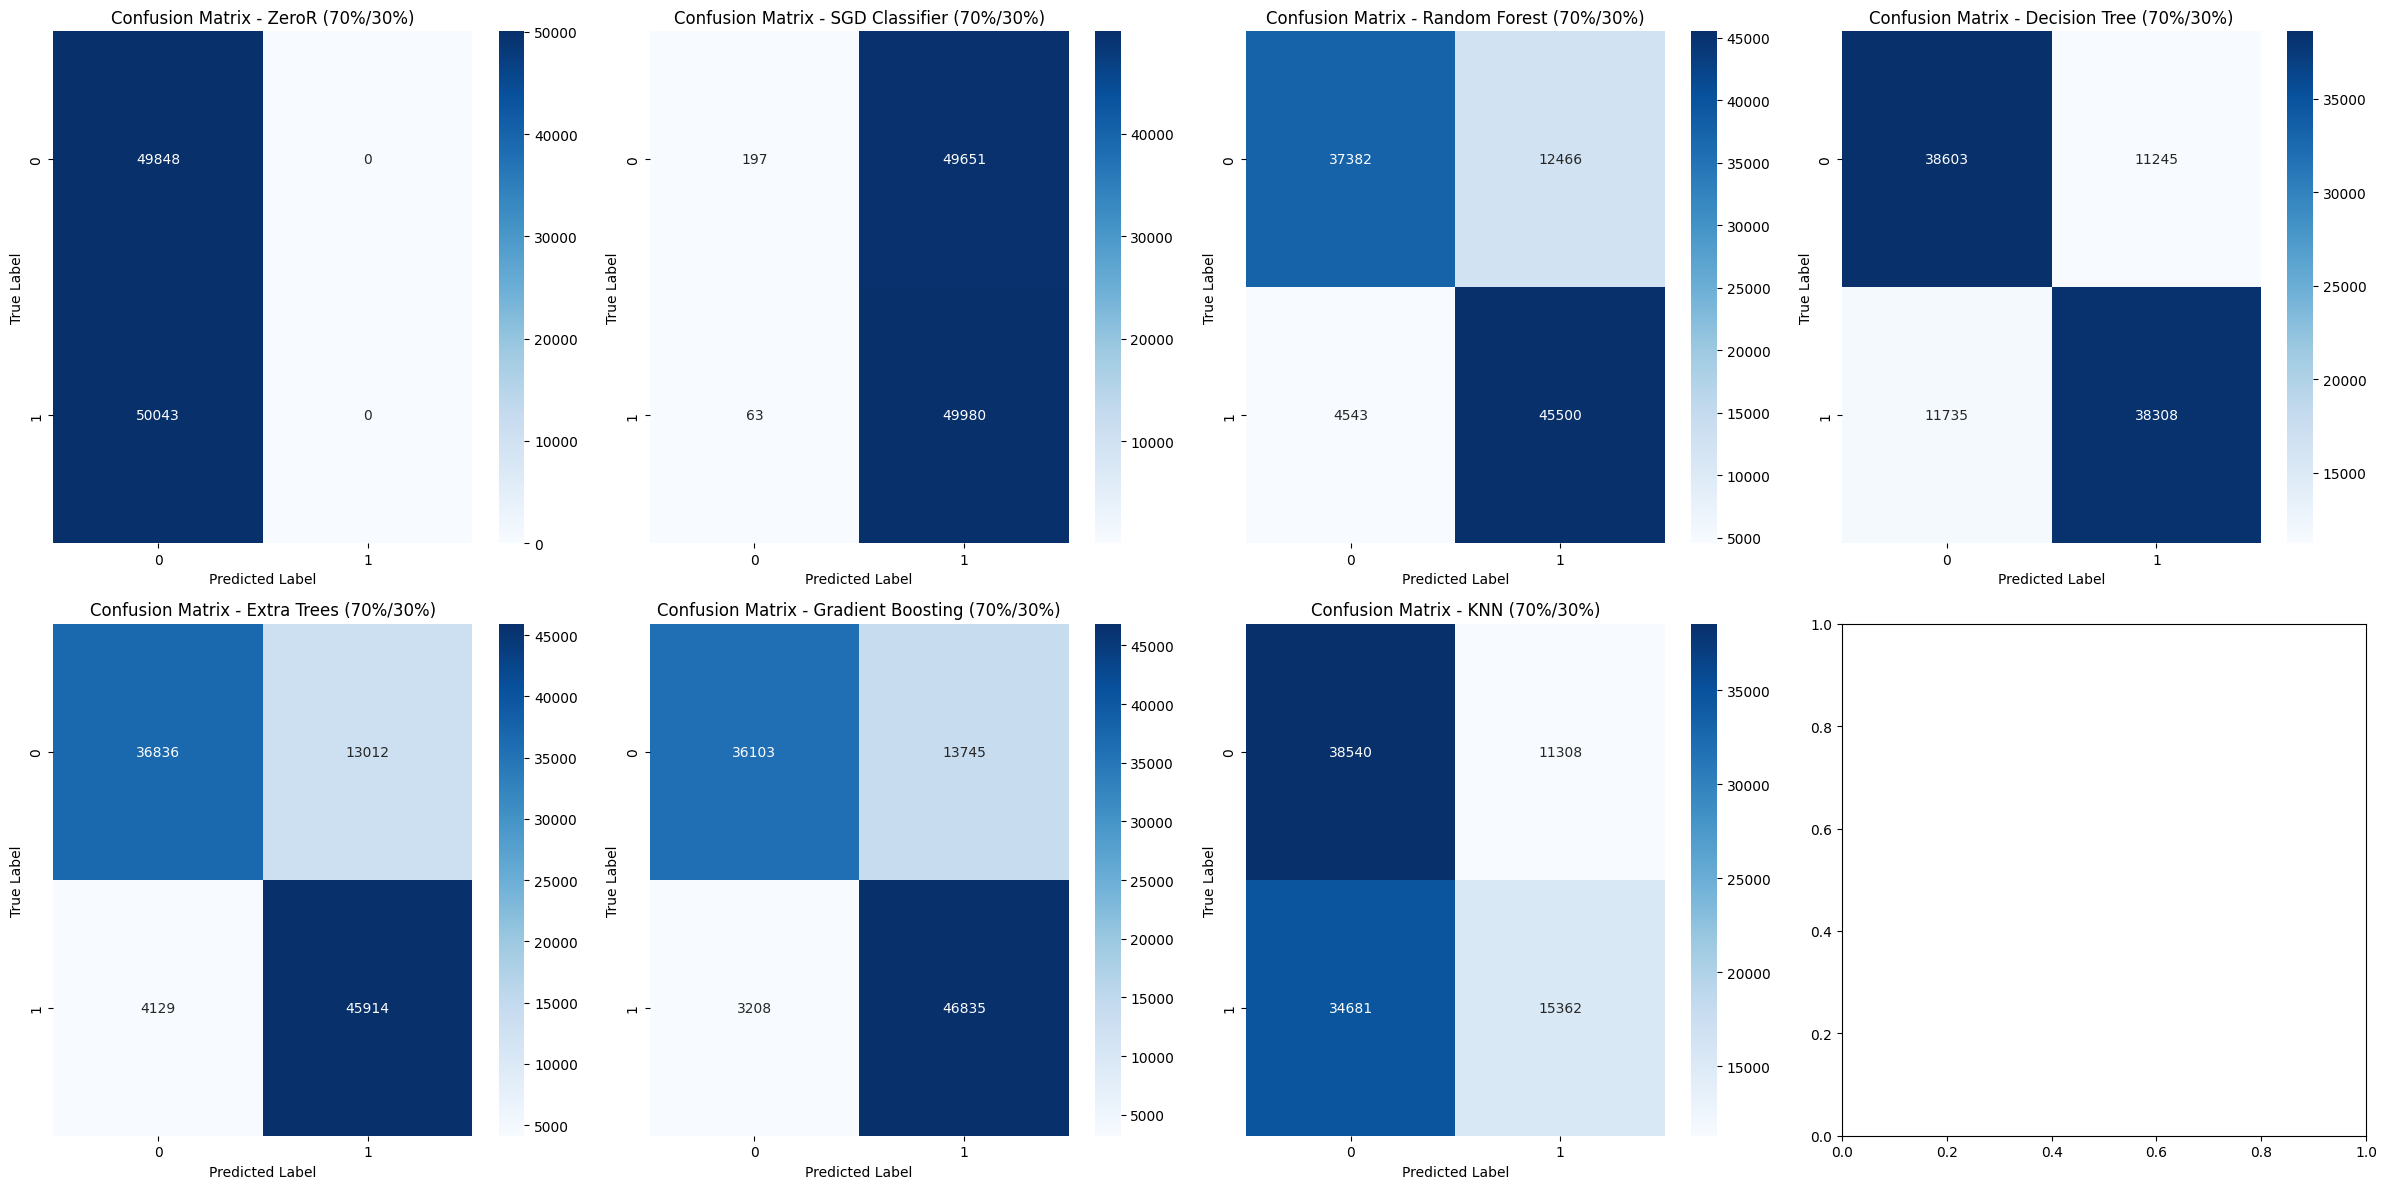


Training/Testing Split: 50%/50%

Model: ZeroR
 Accuracy: 0.4997, Precision: 0.7498, Recall: 0.5000, F1-Score: 0.3332, Specificity: 0.5000
Time taken: 0.09 seconds

Model: SGD Classifier
 Accuracy: 0.5231, Precision: 0.6369, Recall: 0.5234, F1-Score: 0.3987, Specificity: 0.5234
Time taken: 10.02 seconds

Model: Random Forest
 Accuracy: 0.8298, Precision: 0.8381, Recall: 0.8298, F1-Score: 0.8288, Specificity: 0.8298
Time taken: 35.73 seconds

Model: Decision Tree
 Accuracy: 0.7678, Precision: 0.7678, Recall: 0.7678, F1-Score: 0.7678, Specificity: 0.7678
Time taken: 3.25 seconds

Model: Extra Trees
 Accuracy: 0.8276, Precision: 0.8380, Recall: 0.8275, F1-Score: 0.8262, Specificity: 0.8275
Time taken: 16.93 seconds

Model: Gradient Boosting
 Accuracy: 0.8300, Precision: 0.8447, Recall: 0.8300, F1-Score: 0.8282, Specificity: 0.8300
Time taken: 36.37 seconds

Model: KNN
 Accuracy: 0.5401, Precision: 0.5515, Recall: 0.5402, F1-Score: 0.5136, Specificity: 0.5402
Time taken: 8.91 seconds

Resu

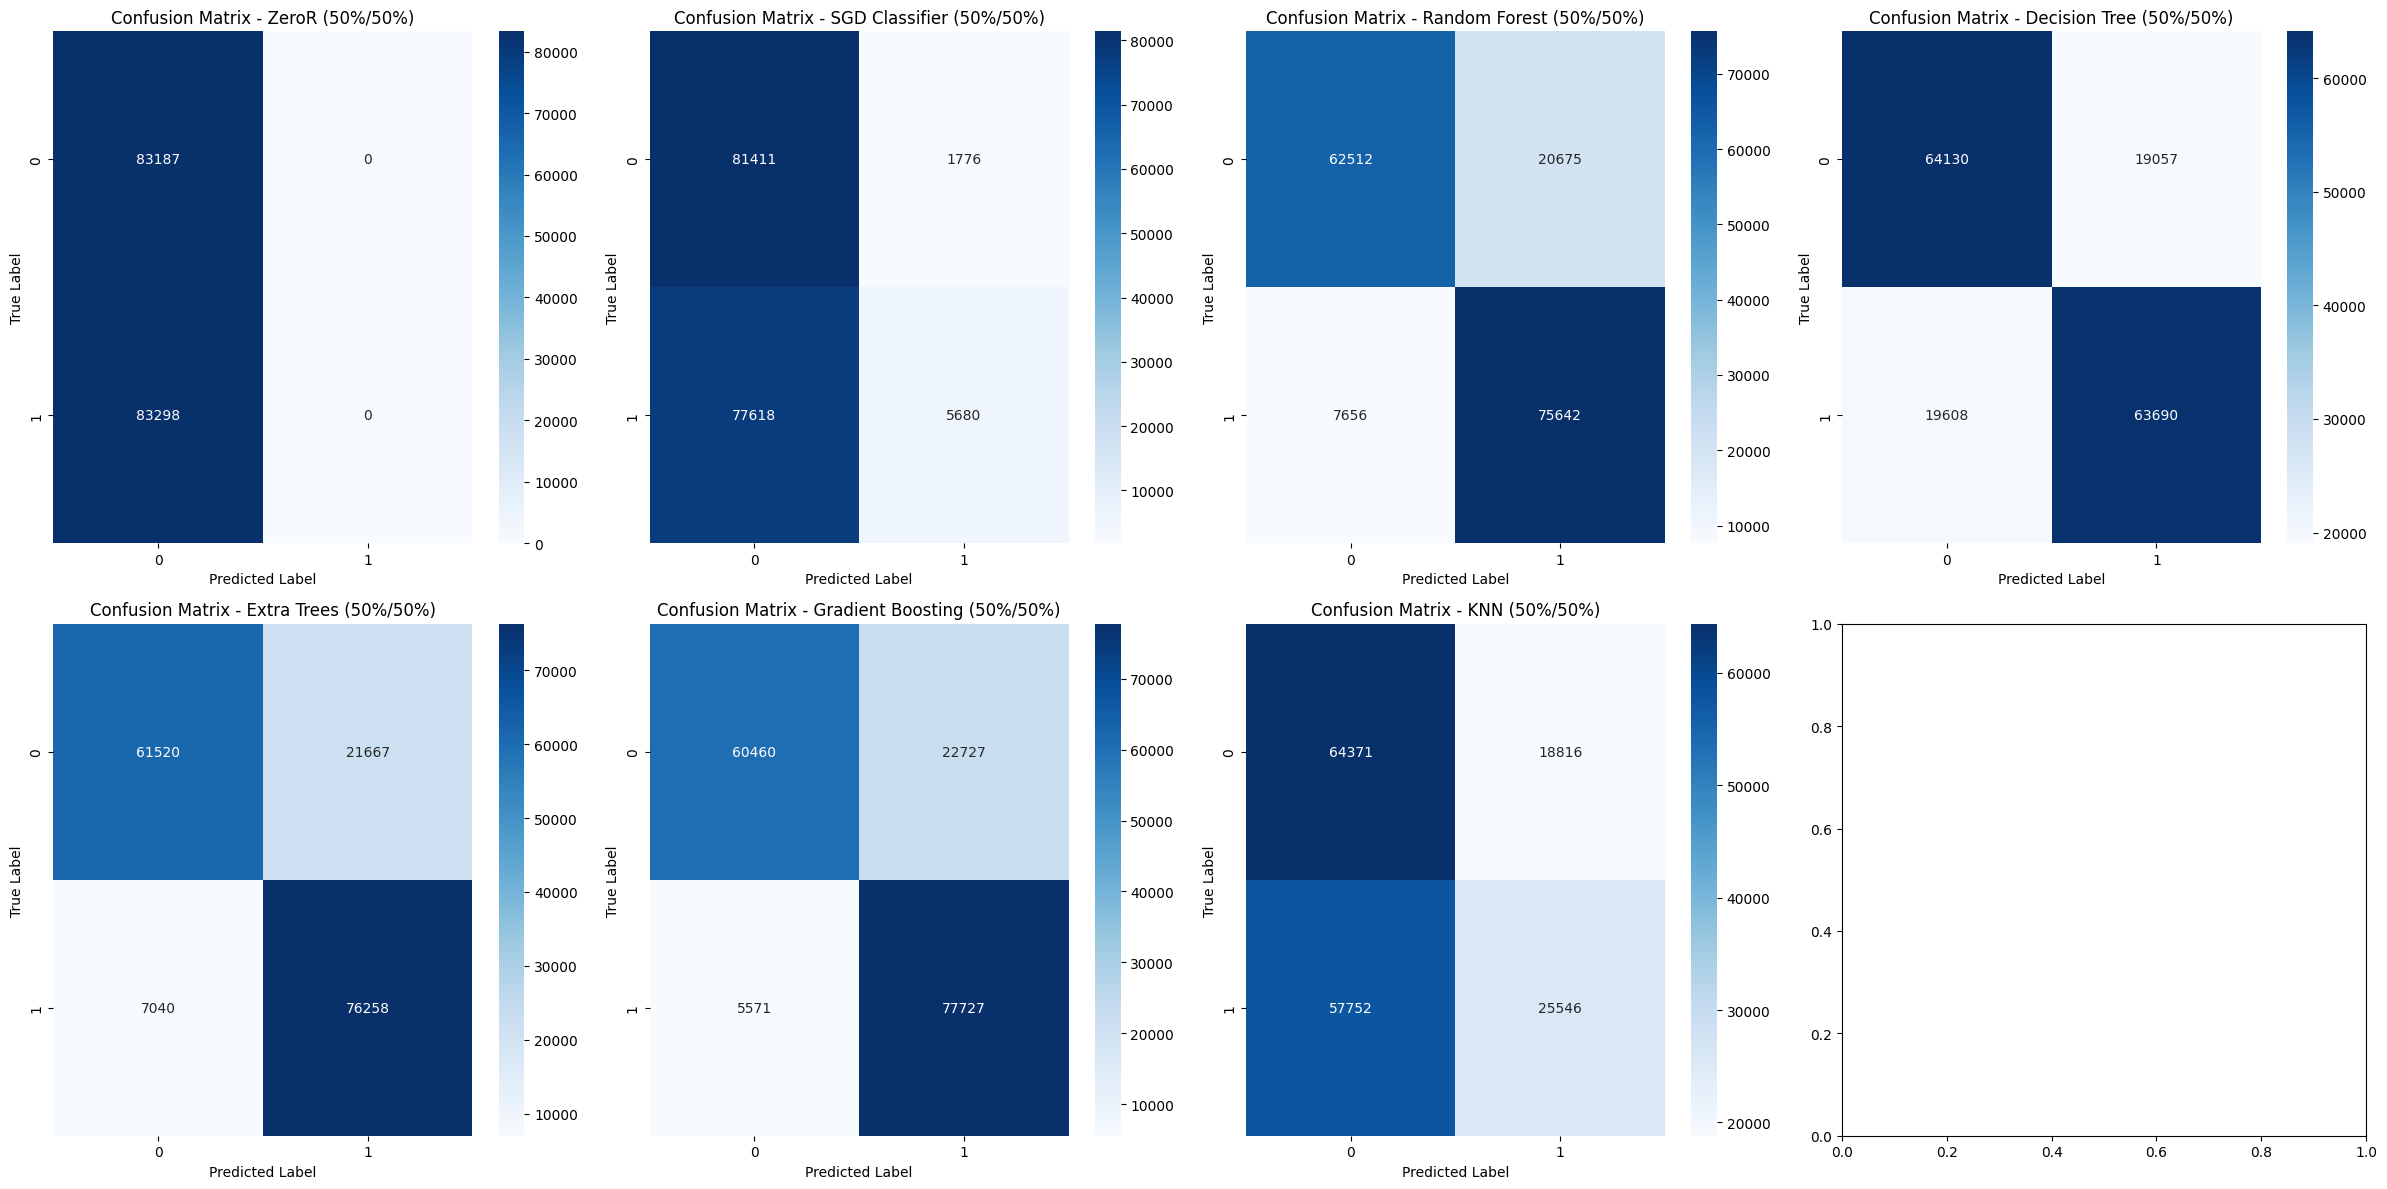

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


results_dir = "BoGender_SPLITS"
os.makedirs(results_dir, exist_ok=True)
# df = pd.read_csv("'../Data/Sampled_data.csv'")

X = df.drop(columns=["BoGender"])
y = df["BoGender"]

splits = [(0.90, 0.10), (0.80, 0.20), (0.70, 0.30), (0.50, 0.50)]

models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    "SGD Classifier": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    # "Logistic Regression": LogisticRegression(
    #     max_iter=1000, 
    #     random_state=42, 
    #     multi_class="multinomial",  # Ensures proper handling of multi-class classification
    #     solver="lbfgs"  # Use "saga" for large datasets
    #     ),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42), 
    "KNN": KNeighborsClassifier(n_neighbors=2),
    # "Support Vector Machine": SVC(kernel="rbf", probability=True, random_state=42),  
}

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

for train_size, test_size in splits:
    train_percent = int(train_size * 100)
    test_percent = int(test_size * 100)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    print(f"\nTraining/Testing Split: {train_percent}%/{test_percent}%\n")
    
    results = {}
    conf_matrices = {}
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='macro', zero_division=1)
        rec = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        spec = specificity_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        elapsed_time = time.time() - start_time
        
        results[name] = {
            "Accuracy": acc, 
            "Precision": prec, 
            "Recall": rec, 
            "F1-Score": f1, 
            "Specificity": spec,
            "Total Runtime (s)": elapsed_time,
        }
        conf_matrices[name] = cm
        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds\n".format(elapsed_time))
        
    results_df = pd.DataFrame(results).T
    results_file = f"{results_dir}/results_split_{train_percent}_{test_percent}.csv"
    results_df.to_csv(results_file, index=True)
    print(f"Results saved to {results_file}")

    for name, cm in conf_matrices.items():
        cm_file = f"{results_dir}/conf_matrix_{train_percent}_{test_percent}_{name.replace(' ', '_')}.csv"
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.ravel()
    
    for i, (name, cm) in enumerate(conf_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name} ({train_percent}%/{test_percent}%)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Create results directory if not exists
cv_results_dir = "cv_results"
os.makedirs(cv_results_dir, exist_ok=True)

# Load the dataset
df = pd.read_csv("merged_data_step_3_sampled_v2.csv", low_memory=False) 

# Define features and target
X = df.drop(columns=["Borrower Credit Score"])
y = df["Borrower Credit Score"]

# Define models
models = {
    "ZeroR": DummyClassifier(strategy="most_frequent"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42),
    # "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    # "KNN": KNeighborsClassifier(n_neighbors=5),
}

# Function to calculate specificity
def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = np.sum(cm) - np.sum(cm, axis=0) - np.sum(cm, axis=1) + np.diag(cm)  # True Negatives per class
    fp = np.sum(cm, axis=0) - np.diag(cm)  # False Positives per class
    specificity_per_class = tn / (tn + fp)  # Compute specificity per class
    return np.mean(specificity_per_class)  # Return the average specificity

# Define number of folds for cross-validation
folds_list = [5, 10, 20]

# Iterate over each number of folds
for num_folds in folds_list:
    print(f"\nPerforming {num_folds}-fold cross-validation\n")
    kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    results = {}
    conf_matrices = {}
    
    for name, model in models.items():
        start_time = time.time()
        y_pred = cross_val_predict(model, X, y, cv=kf)
        total_runtime = time.time() - start_time  # End timing
        
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average='weighted', zero_division=1)
        rec = recall_score(y, y_pred, average='weighted')
        f1 = f1_score(y, y_pred, average='weighted')
        spec = specificity_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        
        results[name] = {
            "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1,
            "Specificity": spec, "Total Runtime (s)": total_runtime, "Total Runtime (min)": total_runtime / 60
        }
        
        conf_matrices[name] = cm
        
        print(f"Model: {name}\n Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, Specificity: {spec:.4f}")
        print("Time taken: {:.2f} seconds".format(total_runtime))
        print("Time taken: {:.2f} minutes\n".format(total_runtime / 60))
    
    # Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results).T
    results_file = f"{cv_results_dir}/results_cv_{num_folds}_folds.csv"
    results_df.to_csv(results_file, index=True)
    print(f"Results saved to {results_file}")

    # Save confusion matrices
    for name, cm in conf_matrices.items():
        cm_file = f"{cv_results_dir}/conf_matrix_cv_{num_folds}_folds_{name.replace(' ', '_')}.csv"
        pd.DataFrame(cm).to_csv(cm_file, index=False)
        print(f"Confusion Matrix for {name} saved to {cm_file}")
    
    # Plot confusion matrices
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.ravel()
    
    for i, (name, cm) in enumerate(conf_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name} ({num_folds}-Folds CV)')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
